<a href="https://colab.research.google.com/github/3ZadeSSG/Minor-Project-Sentiment-Analysis/blob/master/Sentiment_Analysis_using_Stanford_AI_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files,drive

In [0]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [1]:
# Get the generated helper functions to process the data and create proper datasets to be converted into tensors
!wget -c https://raw.githubusercontent.com/3ZadeSSG/Minor-Project-Sentiment-Analysis/master/myModelHelper.py

--2019-03-30 17:25:10--  https://raw.githubusercontent.com/3ZadeSSG/Minor-Project-Sentiment-Analysis/master/myModelHelper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2509 (2.5K) [text/plain]
Saving to: ‘myModelHelper.py’

myModelHelper.py    100%[===================>]   2.45K  --.-KB/s    in 0s      

2019-03-30 17:25:10 (58.1 MB/s) - ‘myModelHelper.py’ saved [2509/2509]



In [2]:
# Get data directly from url
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2019-03-30 17:25:13--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  23.2MB/s    in 3.5s    

2019-03-30 17:25:17 (23.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
# Extract data
!tar -xvzf aclImdb_v1.tar.gz

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset,DataLoader
from myModelHelper import *
import matplotlib.pyplot as plt


In [0]:
class SentimentNetwork(nn.Module):
  def __init__(self,vocabulary_size,output_size,embedding_dimension,hidden_dimension,number_of_layers,dropout_probability=0.5):
    super(SentimentNetwork,self).__init__()
    # class data for weight matrix size
    self.output_size=output_size
    self.number_of_layers=number_of_layers
    self.hidden_dimension=hidden_dimension
    # create the embedding layer to reduce dimension 
    # and LSTM layer containing LSTM cells 
    self.embedding=nn.Embedding(vocabulary_size,embedding_dimension)
    self.lstm=nn.LSTM(embedding_dimension,hidden_dimension,number_of_layers,dropout=dropout_probability,batch_first=True)
    
    # Create dropout layer as a regularization method to reduct overfitting
    # this will disable some units in forward pass, thus preventing 
    # a particular set of node's weights getting updated while others remain unused
    self.dropout=nn.Dropout(dropout_probability)
    
    # attach final  linear layer with sigmoid function
   
    self.finalLayer=nn.Linear(hidden_dimension,output_size)
    self.sigmoid=nn.Sigmoid()
   
  def forward(self,x,hidden):
    batch_size=x.size(0)
    embedding_output=self.embedding(x)
    
    #lstm will take the current input and hidden state as input 
    # and will generate the output to be feed at the linear layer
    lstm_output,hidden=self.lstm(embedding_output,hidden)
    lstm_output=lstm_output.contiguous().view(-1,self.hidden_dimension)
    
    output=self.dropout(lstm_output)
    output=self.finalLayer(output)
    
    #call the sigmoid function on current output of final layer
    sigmoid_output=self.sigmoid(output)
    sigmoid_output=sigmoid_output.view(batch_size,-1)
    #only get the last position output for all batches
    sigmoid_output=sigmoid_output[:,-1]
    
    #current sigmoid output and a hidden state to be fed as input for next pass
    # into the LSTM cells, so that they will be dependent on the previous state
    return sigmoid_output,hidden
  
  def initialize_hidden_state(self,batch_size):
    # At first the hidden state will not hold any information, hence we need to
    # initialize them with zeros
    # Number_of_Layers x Batch_Size x Hidden_Dimension
    weight=next(self.parameters()).data
    if(torch.cuda.is_available()):
      # if GPU is available then initialize the weights parallely
      hidden=(weight.new(self.number_of_layers,batch_size,self.hidden_dimension).zero_().cuda(),weight.new(self.number_of_layers,batch_size,self.hidden_dimension).zero_().cuda())
    else:
      hidden=(weight.new(self.number_of_layers,batch_size,self.hidden_dimension).zero_(),weight.new(self.number_of_layers,batch_size,self.hidden_dimension).zero_())
      
    return hidden
      
   

In [0]:
def buildNetwork():
  #Our model parameters
  vocabulary_size=len(vocab_to_int)+1
  output_size=1
  embedding_dimension=200
  hidden_dimension=256
  number_of_layers=2
  
  model=SentimentNetwork(vocabulary_size,output_size,embedding_dimension,hidden_dimension,number_of_layers)
  
  # Alpha value
  learning_rate=0.003
  
  # Error calculating formula (Mean Square Error)
  criterion = nn.MSELoss() 
 
  #Adam optimization technique for first-order gradient-based optimization
  optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
  return model,criterion,optimizer
  

In [0]:
def trainNetwork(model,clip_value,epochs,print_interval,criterion,optimizer):
  Iteration=[]
  Training_Loss=[]
  Validation_Loss=[]
  
  minimum_validation_loss=np.Inf
  
  # Since each epoch goes over all data and
  # each iteration goes over the data in batches
  count=0
  
  # move model to GPU 
  model.cuda()
  
  #put the model into training model so that the gradients will 
  # be calculated
  model.train()
  for i in range(epochs):
    # for each epoch perform a forward pass for all batches
    # and around epoch 4 reduce the learning rate
    hidden_state=model.initialize_hidden_state(batch_size)
    if(i==3):
      print("\n\nReducing the learning rate!\n" )
      optimizer=torch.optim.Adam(model.parameters(),lr=0.0002)
    
    for inputs,labels in train_loader:
      count+=1
      # move the data to GPU
      inputs,labels=inputs.cuda(),labels.cuda()
      
      #create new variable for hidden state otherwise it will include all
      #pervious states
      hidden_state=tuple([element.data for element in hidden_state])
      
      model.zero_grad()
      
      inputs=inputs.long()
      output,hidden_state=model(inputs,hidden_state)
      
      #calculate the loss to backpropagare to model
      loss=torch.sqrt(criterion(output.squeeze(),labels.float()))
      loss.backward()

      
      nn.utils.clip_grad_norm_(model.parameters(),clip)
      optimizer.step()
      
      if(count%print_interval==0):
        temp_hidden=model.initialize_hidden_state(batch_size)
        temp_losses=[]
        model.eval()
        for inputs,labels in validation_loader:
          temp_hidden=tuple([element.data for element in temp_hidden])
          inputs,labels=inputs.cuda().long(),labels.cuda()
          
          output,temp_hidden=model(inputs,temp_hidden)
          validation_loss=criterion(output.squeeze(),labels.float())
          temp_losses.append(validation_loss.item())
        
        model.train()
        print("Epoch: {}\tIteration: {}\tTraining Loss: {:.7f}\tValidation Loss: {:.7f}".format(
        (i+1),count,loss.item(),np.mean(temp_losses)))
        Iteration.append(count)
        Training_Loss.append(loss.item())
        Validation_Loss.append(np.mean(temp_losses))
        
        if np.mean(temp_losses)<minimum_validation_loss:
            save_checkpoint(model,"checkpoint.pth")
            minimum_validation_loss=np.mean(temp_losses)
            print("Validation loss decreased  hence saving checkpoint successfully")
                  
         


  plt.plot(Iteration,Training_Loss)
  plt.plot(Iteration,Validation_Loss)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.legend(['Training Loss','Validation Loss'], loc='upper left')
  plt.show()
  
        

In [0]:
def save_checkpoint(model,fileLocation):
  # save the current state_dict which contains all the weights of the network
  torch.save(model.state_dict(),fileLocation)
  

In [0]:
def load_Checkpoint(fileLocation):
  model=buildNetwork()
  model.load_state_dict(torch.load(fileLocation))

In [0]:
def checkAccuracy(model,test_loader):
  #move model to GPU
  model.cuda()
  
  test_losses=[]
  correct_prediction=0
  
  #set initial state to zero
  hidden_state=model.initialize_hidden_state(batch_size)
  
  # set the model into evaluation mode, so that we don't need to calculate
  # the gradients
  model.eval()
  
  for inputs,labels in test_loader:
    
    # move the data and labels into GPU
    inputs,labels=inputs.cuda().long(),labels.cuda().long()
    
    output,hidden_state=model(inputs,hidden_state)
    # labels are initially long or int, we need to conver them into float
    # so that loss cab be calculated in float value
    test_loss=criterion(output.squeeze(),labels.float())
    test_losses.append(test_loss.item())
    
    # get the prediction either 1 or 0
    prediction=torch.round(output.squeeze())
    
    correct_tensor=prediction.eq(labels.float().view_as(prediction))   
    correct=np.squeeze(correct_tensor.cpu().numpy())
    correct_prediction+=np.sum(correct)
  
  #print(np.mean(test_losses))
  print("Accuracy: {:.4f}".format(correct_prediction/len(test_loader.dataset)))
  

In [0]:
def tokenize_sentence(sentence):
  sentence=sentence.lower()
  
  #remove punctuation
  sentence=''.join([letter for letter in sentence if letter not in punctuation])
  
  test_words=sentence.split()
  tokens=[]
  sample=[]
  for word in test_words:
      if word in vocab_to_int:
          sample.append(word)
  tokens.append([vocab_to_int[word] for word in sample])
  return tokens

In [0]:
def predict(model,sentence,sequence_length=200):
  model.cuda()
  model.eval()
  
  test_ints=tokenize_sentence(sentence)
  features=featuresPadding(test_ints,sequence_length)
  feature_tensor=torch.from_numpy(features)
  batch_size=feature_tensor.size(0)
  
  hidden_state=model.initialize_hidden_state(batch_size)
  feature_tensor=feature_tensor.cuda().long()
  output,hidden_state=model(feature_tensor,hidden_state)
  prediction=torch.round(output.squeeze())
  if(prediction.item()==0):
    print("{:.4f}\t Positive sentence!".format(output.item()))
  else:
    print("{:.4f}\t Negative sentence!".format(output.item()))
  

In [0]:
positiveDataPath="aclImdb/train/neg/"
negativeDataPath="aclImdb/train/pos/"
fileLocation='/content/drive/My Drive/SEM-III Project/SentimentAnalysisCheckpoint.pth'

In [0]:
reviews,labels=createData(positiveDataPath,negativeDataPath)

In [31]:
len(reviews),len(labels)

(33151741, 225000)

In [0]:
seq_length=200

In [0]:
features,encoded_labels,vocab_to_int=getFeaturesLabels(reviews,labels,seq_length)

train_x,train_y,test_x,test_y,val_x,val_y=createTrainTestValidateData(0.8,features,encoded_labels)

In [0]:
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validation_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
batch_size=100
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(validation_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [43]:
print("Training: \t",np.shape(train_x))
print("Validation: \t",np.shape(val_x))
print("Test: \t\t",np.shape(test_x))


Training: 	 (20000, 200)
Validation: 	 (2500, 200)
Test: 		 (2500, 200)


In [0]:
model,criterion,optimizer=buildNetwork()

In [70]:
model.cuda()

SentimentNetwork(
  (embedding): Embedding(121365, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (finalLayer): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [0]:
clip=5 
print_interval = 100
epochs = 16 

Epoch: 1	Iteration: 100	Training Loss: 0.4219518	Validation Loss: 0.6297578
Validation loss decreased  hence saving checkpoint successfully
Epoch: 1	Iteration: 200	Training Loss: 0.4450566	Validation Loss: 0.3370963
Validation loss decreased  hence saving checkpoint successfully
Epoch: 2	Iteration: 300	Training Loss: 0.3880105	Validation Loss: 0.3536352
Epoch: 2	Iteration: 400	Training Loss: 0.3151176	Validation Loss: 0.1723209
Validation loss decreased  hence saving checkpoint successfully
Epoch: 3	Iteration: 500	Training Loss: 0.2903425	Validation Loss: 0.1232164
Validation loss decreased  hence saving checkpoint successfully
Epoch: 3	Iteration: 600	Training Loss: 0.3187792	Validation Loss: 0.1749995


Reducing the learning rate!

Epoch: 4	Iteration: 700	Training Loss: 0.1770783	Validation Loss: 0.1717986
Epoch: 4	Iteration: 800	Training Loss: 0.2397028	Validation Loss: 0.1490114
Epoch: 5	Iteration: 900	Training Loss: 0.2651037	Validation Loss: 0.1423358
Epoch: 5	Iteration: 1000	Trai

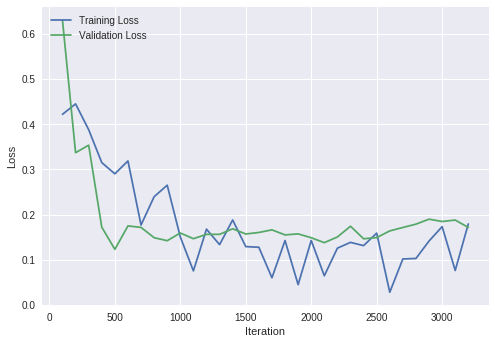

In [72]:
trainNetwork(model,clip,epochs,print_interval,criterion,optimizer)

In [0]:
# saving the trained model to google drive
save_checkpoint(model,fileLocation)

In [73]:
checkAccuracy(model,test_loader)

Accuracy: 0.7888


In [75]:
checkAccuracy(model,train_loader)

Accuracy: 0.9859


In [74]:
checkAccuracy(model,validation_loader)

Accuracy: 0.8088


In [0]:
predict(model, 'Kamikaze album by eminem has to be one of the best albums that came out last year, other than few tracks, evey track was lit', seq_length)

0.1061	 Positive sentence!


In [0]:
sentence = 'Drake published 3 trash albums this year, each track gave pain at different parts of my brain, he deserves rotten tomatoes'
predict(model,sentence)

0.9934	 Negative sentence!
